In [41]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [53]:
# Copyright (c) 2012-2018 by the GalSim developers team on GitHub
# https://github.com/GalSim-developers
#
# This file is part of GalSim: The modular galaxy image simulation toolkit.
# https://github.com/GalSim-developers/GalSim
#
# GalSim is free software: redistribution and use in source and binary forms,
# with or without modification, are permitted provided that the following
# conditions are met:
#
# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions, and the disclaimer given in the accompanying LICENSE
#    file.
# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions, and the disclaimer given in the documentation
#    and/or other materials provided with the distribution.
#
"""
Demo #3

The third script in our tutorial about using GalSim in python scripts: examples/demo*.py.
(This file is designed to be viewed in a window 100 characters wide.)

This script gets reasonably close to including all the principal features of an image
from a ground-based telescope.  The galaxy is represented as the sum of a bulge and a disk,
where each component is represented by a sheared Sersic profile (with different Sersic
indices).  The PSF has both atmospheric and optical components.  The atmospheric
component is a Kolmogorov turbulent spectrum.  The optical component includes defocus,
coma and astigmatism, as well as obscuration from a secondary mirror.  The noise model
includes both a gain and read noise.  And finally, we include the effect of a slight
telescope distortion.

New features introduced in this demo:

- obj = galsim.Sersic(n, flux, half_light_radius)
- obj = galsim.Sersic(n, flux, scale_radius)
- obj = galsim.Kolmogorov(fwhm)
- obj = galsim.OpticalPSF(lam_over_diam, defocus, coma1, coma2, astig1, astig2, obscuration)
- obj = obj.shear(e, beta)  -- including how to specify an angle in GalSim
- shear = galsim.Shear(q, beta)
- obj = obj.shear(shear)
- obj3 = x1 * obj1 + x2 * obj2
- obj = obj.withFlux(flux)
- image = galsim.ImageF(image_size, image_size)
- image = obj.drawImage(image, wcs)
- image = obj.drawImage(method='sb')
- world_profile = wcs.toWorld(profile)
- shear3 = shear1 + shear2
- noise = galsim.CCDNoise(rng, sky_level, gain, read_noise)
"""

import sys
import os
import math
import logging
import galsim

########
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
# plt.style.use(astropy_mpl_style)
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
#######

def main(argv):
    """
    Getting reasonably close to including all the principle features of an image from a
    ground-based telescope:
      - Use a bulge plus disk model for the galaxy
      - Both galaxy components are Sersic profiles (n=3.5 and n=1.5 respectively)
      - Let the PSF have both atmospheric and optical components.
      - The atmospheric component is a Kolmogorov spectrum.
      - The optical component has some defocus, coma, and astigmatism.
      - Add both Poisson noise to the image and Gaussian read noise.
      - Let the pixels be slightly distorted relative to the sky.
    """
    # We do some fancier logging for demo3, just to demonstrate that we can:
    # - we log to both stdout and to a log file
    # - the log file has a lot more (mostly redundant) information
    logging.basicConfig(format="%(message)s", level=logging.INFO, stream=sys.stdout)
    if not os.path.isdir('output'):
        os.mkdir('output')
    logFile = logging.FileHandler(os.path.join("output", "script3.log"))
    logFile.setFormatter(logging.Formatter("%(name)s[%(levelname)s] %(asctime)s: %(message)s"))
    logging.getLogger("demo3").addHandler(logFile)
    logger = logging.getLogger("demo3")

    gal_flux = 1.e6        # ADU  ("Analog-to-digital units", the units of the numbers on a CCD)
    bulge_n = 3.5          #
    bulge_re = 4         # arcsec
    disk_n = 1.5           #
    disk_r0 = 0.85         # arcsec (corresponds to half_light_radius of ~3.7 arcsec)
    bulge_frac = 0.3       #
    gal_q = 0.73           # (axis ratio 0 < q < 1)
    gal_beta = 23          # degrees (position angle on the sky)
    atmos_fwhm=2.1         # arcsec
    atmos_e = 0.13         #
    atmos_beta = 0.81      # radians
    opt_defocus=0.53       # wavelengths
    opt_a1=-0.29           # wavelengths
    opt_a2=0.12            # wavelengths
    opt_c1=0.64            # wavelengths
    opt_c2=-0.33           # wavelengths
    opt_obscuration=0.3    # linear scale size of secondary mirror obscuration
    lam = 800              # nm    NB: don't use lambda - that's a reserved word.
    tel_diam = 4.          # meters
    pixel_scale = 0.23     # arcsec / pixel
    image_size = 64        # n x n pixels
    wcs_g1 = -0.02         #
    wcs_g2 = 0.01          #
    sky_level = 2.5e4      # ADU / arcsec^2
    gain = 1.7             # e- / ADU
                           # Note: here we assume 1 photon -> 1 e-, ignoring QE.  If you wanted,
                           # you could include the QE factor as part of the gain.
    read_noise = 0.3       # e- / pixel

    random_seed = 1314662

    logger.info('Starting demo script 3 using:')
    logger.info('    - Galaxy is bulge plus disk, flux = %.1e',gal_flux)
    logger.info('       - Bulge is Sersic (n = %.1f, re = %.2f), frac = %.1f',
                bulge_n,bulge_re,bulge_frac)
    logger.info('       - Disk is Sersic (n = %.1f, r0 = %.2f), frac = %.1f',
                disk_n,disk_r0,1-bulge_frac)
    logger.info('       - Shape is q,beta (%.2f,%.2f deg)', gal_q, gal_beta)
    logger.info('    - Atmospheric PSF is Kolmogorov with fwhm = %.2f',atmos_fwhm)
    logger.info('       - Shape is e,beta (%.2f,%.2f rad)', atmos_e, atmos_beta)
    logger.info('    - Optical PSF has defocus = %.2f, astigmatism = (%.2f,%.2f),',
                opt_defocus, opt_a1, opt_a2)
    logger.info('          coma = (%.2f,%.2f), lambda = %.0f nm, D = %.1f m',
                opt_c1, opt_c2, lam, tel_diam)
    logger.info('          obscuration linear size = %.1f',opt_obscuration)
    logger.info('    - pixel scale = %.2f,',pixel_scale)
    logger.info('    - WCS distortion = (%.2f,%.2f),',wcs_g1,wcs_g2)
    logger.info('    - Poisson noise (sky level = %.1e, gain = %.1f).',sky_level, gain)
    logger.info('    - Gaussian read noise (sigma = %.2f).',read_noise)

    # Initialize the (pseudo-)random number generator that we will be using below.
    rng = galsim.BaseDeviate(random_seed+1)

    # Define the galaxy profile.
    # Normally Sersic profiles are specified by half-light radius, the radius that
    # encloses half of the total flux.  However, for some purposes, it can be
    # preferable to instead specify the scale radius, where the surface brightness
    # drops to 1/e of the central peak value.
    bulge = galsim.Sersic(bulge_n, half_light_radius=bulge_re)
    disk = galsim.Sersic(disk_n, scale_radius=disk_r0)

    # Objects may be multiplied by a scalar (which means scaling the flux) and also
    # added to each other.
    gal = bulge_frac * bulge + (1-bulge_frac) * disk
    # Could also have written the following, which does the same thing:
    #   gal = galsim.Add([ bulge.withFlux(bulge_frac) , disk.withFlux(1-bulge_frac) ])
    # Both syntaxes work with more than two summands as well.

    # Set the overall flux of the combined object.
    gal = gal.withFlux(gal_flux)
    # Since the total flux of the components was 1, we could also have written:
    #   gal *= gal_flux
    # The withFlux method will always set the flux to the given value, while `gal *= flux`
    # will multiply whatever the current flux is by the given factor.

    # Set the shape of the galaxy according to axis ratio and position angle
    # Note: All angles in GalSim must have explicit units.  Options are:
    #       galsim.radians
    #       galsim.degrees
    #       galsim.arcmin
    #       galsim.arcsec
    #       galsim.hours
    gal_shape = galsim.Shear(q=gal_q, beta=gal_beta*galsim.degrees)
    gal = gal.shear(gal_shape)
    
    ####################
    original_GalImage = gal.drawImage(scale=pixel_scale)
    file_name_original_GalImage = os.path.join('output','demo3_original_GalImage.fits')
    original_GalImage.write(file_name_original_GalImage)
    ####################
    
    logger.debug('Made galaxy profile')

    # Define the atmospheric part of the PSF.
    # Note: the flux here is the default flux=1.
    atmos = galsim.Kolmogorov(fwhm=atmos_fwhm)
    # For the PSF shape here, we use ellipticity rather than axis ratio.
    # And the position angle can be either degrees or radians.  Here we chose radians.
    atmos = atmos.shear(e=atmos_e, beta=atmos_beta*galsim.radians)
    ####################
    atmos_Image = atmos.drawImage(scale=pixel_scale)
    file_name_atmos_Image = os.path.join('output','demo3_atmos_Image.fits')
    atmos_Image.write(file_name_atmos_Image)
    ####################
    logger.debug('Made atmospheric PSF profile')

    # Define the optical part of the PSF:
    # The first argument of OpticalPSF below is lambda/diam (wavelength of light / telescope
    # diameter), which needs to be in the same units used to specify the image scale.  We are using
    # arcsec for that, so we have to self-consistently use arcsec here, using the following
    # calculation:
    lam_over_diam = lam * 1.e-9 / tel_diam # radians
    lam_over_diam *= 206265  # arcsec
    # Note that we could also have made GalSim do the conversion for us if we did not know the right
    # factor:
    # lam_over_diam = lam * 1.e-9 / tel_diam * galsim.radians
    # lam_over_diam = lam_over_diam / galsim.arcsec
    logger.debug('Calculated lambda over diam = %f arcsec', lam_over_diam)
    # The rest of the values should be given in units of the wavelength of the incident light.
    optics = galsim.OpticalPSF(lam_over_diam,
                               defocus = opt_defocus,
                               coma1 = opt_c1, coma2 = opt_c2,
                               astig1 = opt_a1, astig2 = opt_a2,
                               obscuration = opt_obscuration)
    logger.debug('Made optical PSF profile')

    # So far, our coordinate transformation between image and sky coordinates has been just a
    # scaling of the units between pixels and arcsec, which we have defined as the "pixel scale".
    # This is fine for many purposes, so we have made it easy to treat the coordinate systems
    # this way via the `scale` parameter to commands like drawImage.  However, in general, the
    # transformation between the two coordinate systems can be more complicated than that,
    # including distortions, rotations, variation in pixel size, and so forth.  GalSim can
    # model a number of different "World Coordinate System" (WCS) transformations.  See the
    # docstring for BaseWCS for more information.

    # In this case, we use a WCS that includes a distortion (specified as g1,g2 in this case),
    # which we call a ShearWCS.
    wcs = galsim.ShearWCS(scale=pixel_scale, shear=galsim.Shear(g1=wcs_g1, g2=wcs_g2))
    logger.debug('Made the WCS')

    # Next we will convolve the components in world coordinates.
    psf = galsim.Convolve([atmos, optics])
    final = galsim.Convolve([psf, gal])
    logger.debug('Convolved components into final profile')

    # This time we specify a particular size for the image rather than let GalSim
    # choose the size automatically.  GalSim has several kinds of images that it can use:
    #   ImageF uses 32-bit floats    (like a C float, aka numpy.float32)
    #   ImageD uses 64-bit floats    (like a C double, aka numpy.float64)
    #   ImageS uses 16-bit integers  (usually like a C short, aka numpy.int16)
    #   ImageI uses 32-bit integers  (usually like a C int, aka numpy.int32)
    # If you let the GalSim drawImage command create the image for you, it will create an ImageF.
    # However, you can make a different type if you prefer.  In this case, we still use
    # ImageF, since 32-bit floats are fine.  We just want to set the size explicitly.
    image = galsim.ImageF(image_size, image_size)
    # Draw the image with the given WCS.  Note that we use wcs rather than scale when the
    # WCS is more complicated than just a pixel scale.
    final.drawImage(image=image, wcs=wcs)

    # Also draw the effective PSF by itself and the optical PSF component alone.
    image_epsf = galsim.ImageF(image_size, image_size)
    psf.drawImage(image_epsf, wcs=wcs)

    # We also draw the optical part of the PSF at its own Nyquist-sampled pixel size
    # in order to better see the features of the (highly structured) profile.
    # In this case, we draw a "surface brightness image" using method='sb'.  Rather than
    # integrate the flux over the area of each pixel, this method just samples the surface
    # brightness value at the locations of the pixel centers.  We will encounter a few other
    # drawing methods as we go through this sequence of demos.  cf. demos 7, 8, 10, and 11.
    image_opticalpsf = optics.drawImage(method='sb')
    logger.debug('Made image of the profile')

    # This time, we use CCDNoise to model the real noise in a CCD image.  It takes a sky level,
    # gain, and read noise, so it can be a bit more realistic than the simpler GaussianNoise
    # or PoissonNoise that we used in demos 1 and 2.

    # The sky level for CCDNoise is the level per pixel that contributed to the noise.
    sky_level_pixel = sky_level * pixel_scale**2

    # The gain is in units of e-/ADU.  Technically, one should also account for quantum efficiency
    # (QE) of the detector. An ideal CCD has one electron per incident photon, but real CCDs have
    # QE less than 1, so not every photon triggers an electron.  We are essentially folding
    # the quantum efficiency (and filter transmission and anything else like that) into the gain.
    # The read_noise value is given as e-/pixel.  This is modeled as a pure Gaussian noise
    # added to the image after applying the pure Poisson noise.
    noise = galsim.CCDNoise(rng, gain=gain, read_noise=read_noise, sky_level=sky_level_pixel)
    image.addNoise(noise)
    logger.debug('Added Gaussian and Poisson noise')

    # Write the images to files.
    file_name = os.path.join('output', 'demo3.fits')
    file_name_epsf = os.path.join('output','demo3_epsf.fits')
    file_name_opticalpsf = os.path.join('output','demo3_opticalpsf.fits')
    image.write(file_name)
    image_epsf.write(file_name_epsf)
    image_opticalpsf.write(file_name_opticalpsf)
    logger.info('Wrote image to %r', file_name)
    logger.info('Wrote effective PSF image to %r', file_name_epsf)
    logger.info('Wrote optics-only PSF image (Nyquist sampled) to %r', file_name_opticalpsf)

    # Check that the HSM package, which is bundled with GalSim, finds a good estimate
    # of the shear.
    results = galsim.hsm.EstimateShear(image, image_epsf)

    logger.info('HSM reports that the image has observed shape and size:')
    logger.info('    e1 = %.3f, e2 = %.3f, sigma = %.3f (pixels)', results.observed_shape.e1,
                results.observed_shape.e2, results.moments_sigma)
    logger.info('When carrying out Regaussianization PSF correction, HSM reports')
    logger.info('    e1, e2 = %.3f, %.3f',
                results.corrected_e1, results.corrected_e2)
    logger.info('Expected values in the limit that noise and non-Gaussianity are negligible:')
    # Convention for shear addition is to apply the second term initially followed by the first.
    # So this needs to be the WCS shear + the galaxy shape in that order.
    total_shape = galsim.Shear(g1=wcs_g1, g2=wcs_g2) + gal_shape
    logger.info('    e1, e2 = %.3f, %.3f', total_shape.e1, total_shape.e2)

if __name__ == "__main__":
    main(sys.argv)

Starting demo script 3 using:
    - Galaxy is bulge plus disk, flux = 1.0e+06
       - Bulge is Sersic (n = 3.5, re = 4.00), frac = 0.3
       - Disk is Sersic (n = 1.5, r0 = 0.85), frac = 0.7
       - Shape is q,beta (0.73,23.00 deg)
    - Atmospheric PSF is Kolmogorov with fwhm = 2.10
       - Shape is e,beta (0.13,0.81 rad)
    - Optical PSF has defocus = 0.53, astigmatism = (-0.29,0.12),
          coma = (0.64,-0.33), lambda = 800 nm, D = 4.0 m
          obscuration linear size = 0.3
    - pixel scale = 0.23,
    - WCS distortion = (-0.02,0.01),
    - Poisson noise (sky level = 2.5e+04, gain = 1.7).
    - Gaussian read noise (sigma = 0.30).
Wrote image to 'output/demo3.fits'
Wrote effective PSF image to 'output/demo3_epsf.fits'
Wrote optics-only PSF image (Nyquist sampled) to 'output/demo3_opticalpsf.fits'
HSM reports that the image has observed shape and size:
    e1 = 0.103, e2 = 0.202, sigma = 10.150 (pixels)
When carrying out Regaussianization PSF correction, HSM reports
    e1

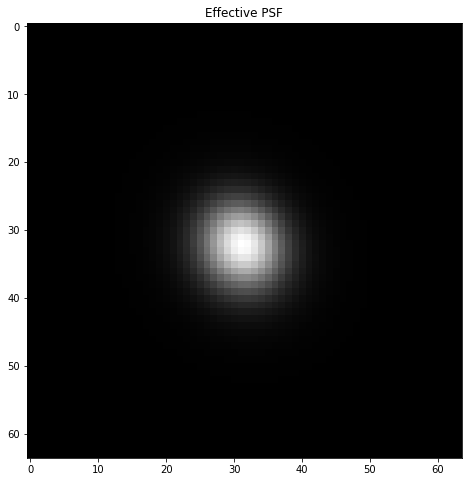

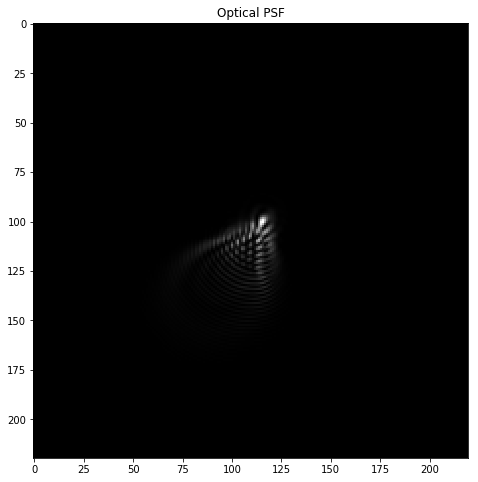

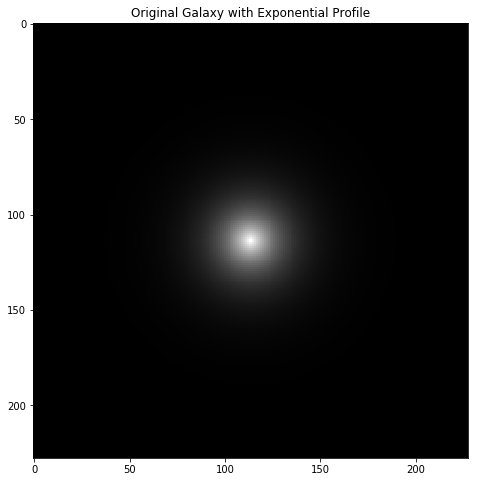

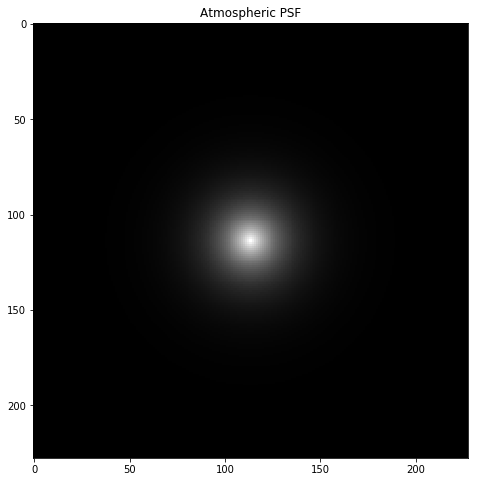

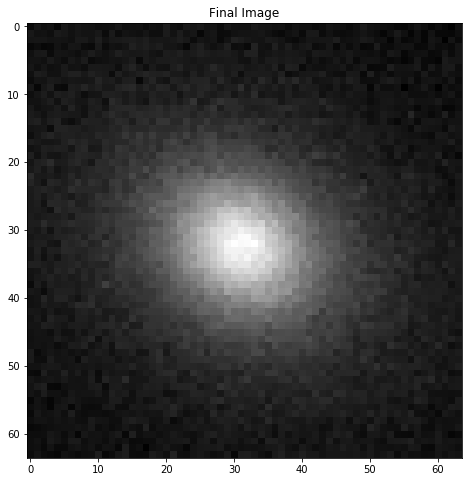

In [57]:
w = 8 
h = 8

epsf_Image_file = get_pkg_data_filename('output/demo3_epsf.fits')
epsf_Image_data = fits.getdata(epsf_Image_file, ext=0)
plt.figure(figsize=(w,h))
plt.title('Effective PSF')
plt.imshow(epsf_Image_data, cmap='gray')

opticalpsf_Image_file = get_pkg_data_filename('output/demo3_opticalpsf.fits')
opticalpsf_Image_data = fits.getdata(opticalpsf_Image_file, ext=0)
plt.figure(figsize=(w,h))
plt.title('Optical PSF')
plt.imshow(opticalpsf_Image_data, cmap='gray')

original_GalImage_file = get_pkg_data_filename('output/demo2_original_GalImage.fits')
original_GalImage_data = fits.getdata(original_GalImage_file, ext=0)
plt.figure(figsize=(w,h))
plt.title('Original Galaxy with Exponential Profile')
plt.imshow(original_GalImage_data, cmap='gray')

atmos_Image_file = get_pkg_data_filename('output/demo3_atmos_Image.fits')
original_atmos_Image_data = fits.getdata(atmos_Image_file, ext=0)
plt.figure(figsize=(w,h))
plt.title('Atmospheric PSF')
plt.imshow(original_GalImage_data, cmap='gray')

demo3_Image_file = get_pkg_data_filename('output/demo3.fits')
demo3_Image_data = fits.getdata(demo3_Image_file, ext=0)
plt.figure(figsize=(w,h))
plt.title('Final Image')
plt.imshow(demo3_Image_data, cmap='gray')